In [13]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from landingai.predict import Predictor
from landingai import visualize
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
image_path = "images/1.jpg"

# Blur Face 

In [15]:
def detect_and_blur_faces(image):
    """
    Detect and blur faces in an image
    """
    # Setup face detector
    BaseOptions = mp.tasks.BaseOptions
    FaceDetector = mp.tasks.vision.FaceDetector
    FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    face_options = FaceDetectorOptions(
        base_options=BaseOptions(model_asset_path='face_detector.task'),
        running_mode=VisionRunningMode.IMAGE,
        min_detection_confidence=0.5
    )

    face_detector = FaceDetector.create_from_options(face_options)
    
    processed_image = image.copy()
    faces_detected = 0

    # Detect and blur faces
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    face_result = face_detector.detect(mp_image)
    
    if face_result.detections:
        for detection in face_result.detections:
            rect = detection.bounding_box
            x, y, w, h = rect.origin_x, rect.origin_y, rect.width, rect.height
            # Ensure coordinates are integers and within image bounds
            x, y, w, h = int(x), int(y), int(w), int(h)
            x, y = max(x, 0), max(y, 0)
            w, h = max(w, 1), max(h, 1)
            if y+h <= processed_image.shape[0] and x+w <= processed_image.shape[1]:
                face_roi = processed_image[y:y+h, x:x+w]
                blurred_face = cv2.GaussianBlur(face_roi, (99, 99), 30)
                processed_image[y:y+h, x:x+w] = blurred_face
                faces_detected += 1

    return processed_image, face_result, faces_detected

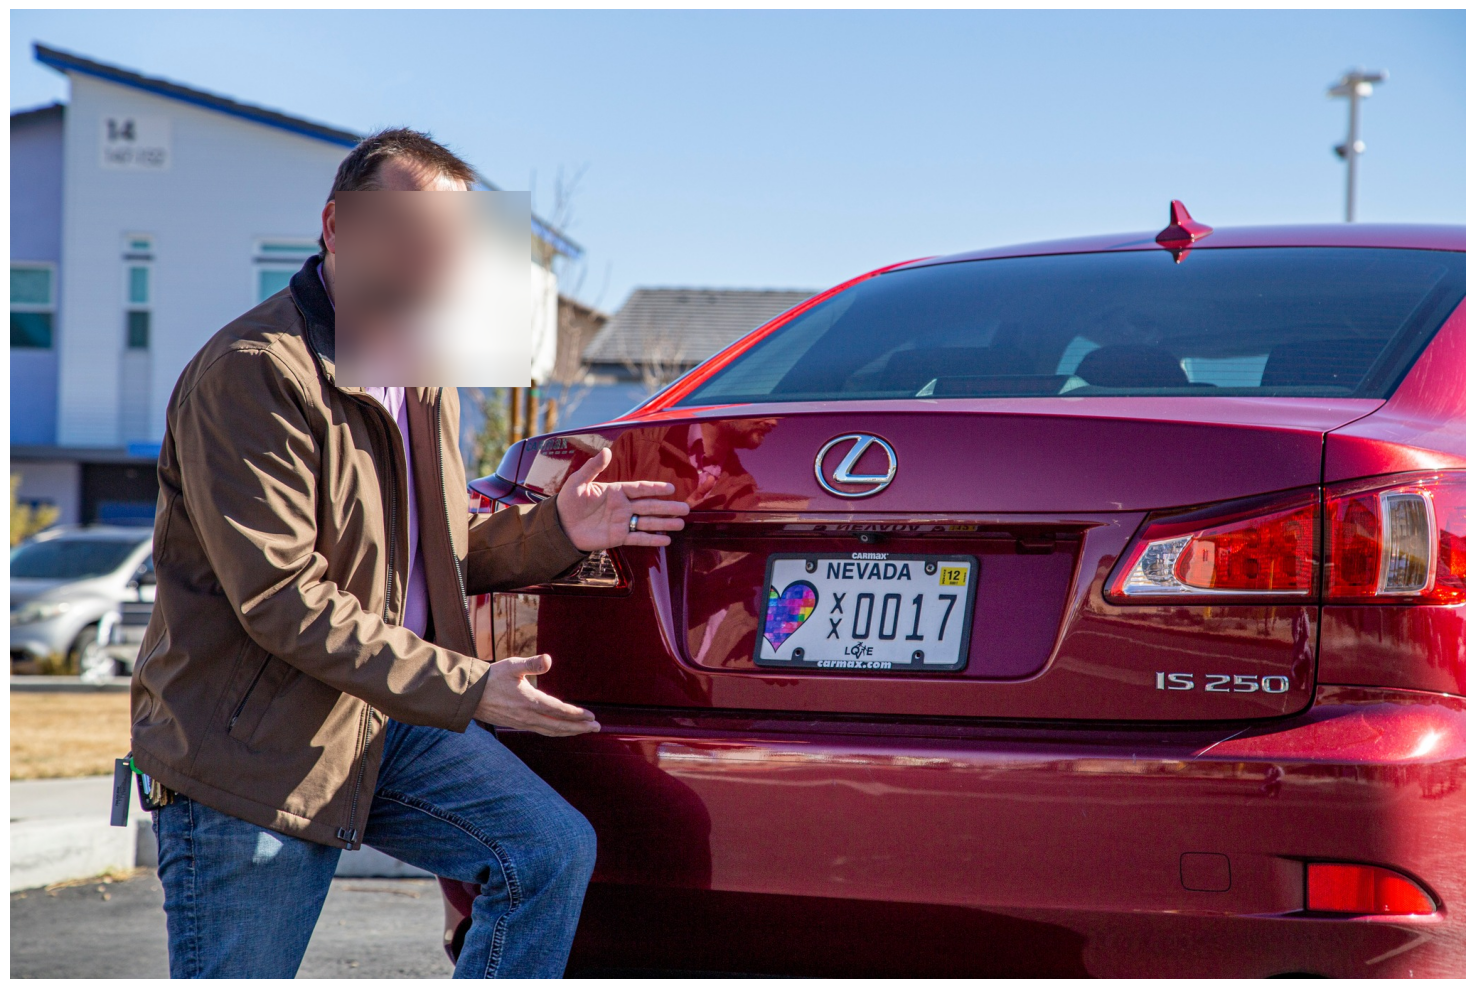

In [16]:
    # Load image
image = cv2.imread(image_path)
if image is None:
    print(f"Could not load image: {image_path}")
    exit()

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process faces first
processed_image, face_result, faces_detected = detect_and_blur_faces(rgb_image)
plt.figure(figsize=(15, 10))
plt.imshow(processed_image)
plt.axis('off')
plt.tight_layout()
plt.show()
    

Blur license plates

In [17]:

def detect_and_blur_plates(image):
    """
    Detect and blur license plates in an image
    """
    # Setup license plate detector
    api_key = "land_sk_aMemWbpd41yXnQ0tXvZMh59ISgRuKNRKjJEIUHnkiH32NBJAwf"
    model_endpoint = "e001c156-5de0-43f3-9991-f19699b31202"
    plate_predictor = Predictor(model_endpoint, api_key=api_key)

    processed_image = image.copy()
    plates_detected = 0

    # Detect and blur license plates
    plate_prediction = plate_predictor.predict(processed_image)
    
    for pred in plate_prediction:
        if pred.label_name == 'number_plate':
            x1, y1, x2, y2 = pred.bboxes
            
            # Extract the license plate region
            plate_region = processed_image[y1:y2, x1:x2]
            
            # Apply Gaussian blur to the region
            blurred_region = cv2.GaussianBlur(plate_region, (51, 51), 0)
            
            # Replace the original region with the blurred one
            processed_image[y1:y2, x1:x2] = blurred_region
            plates_detected += 1

    return processed_image, plate_prediction, plates_detected


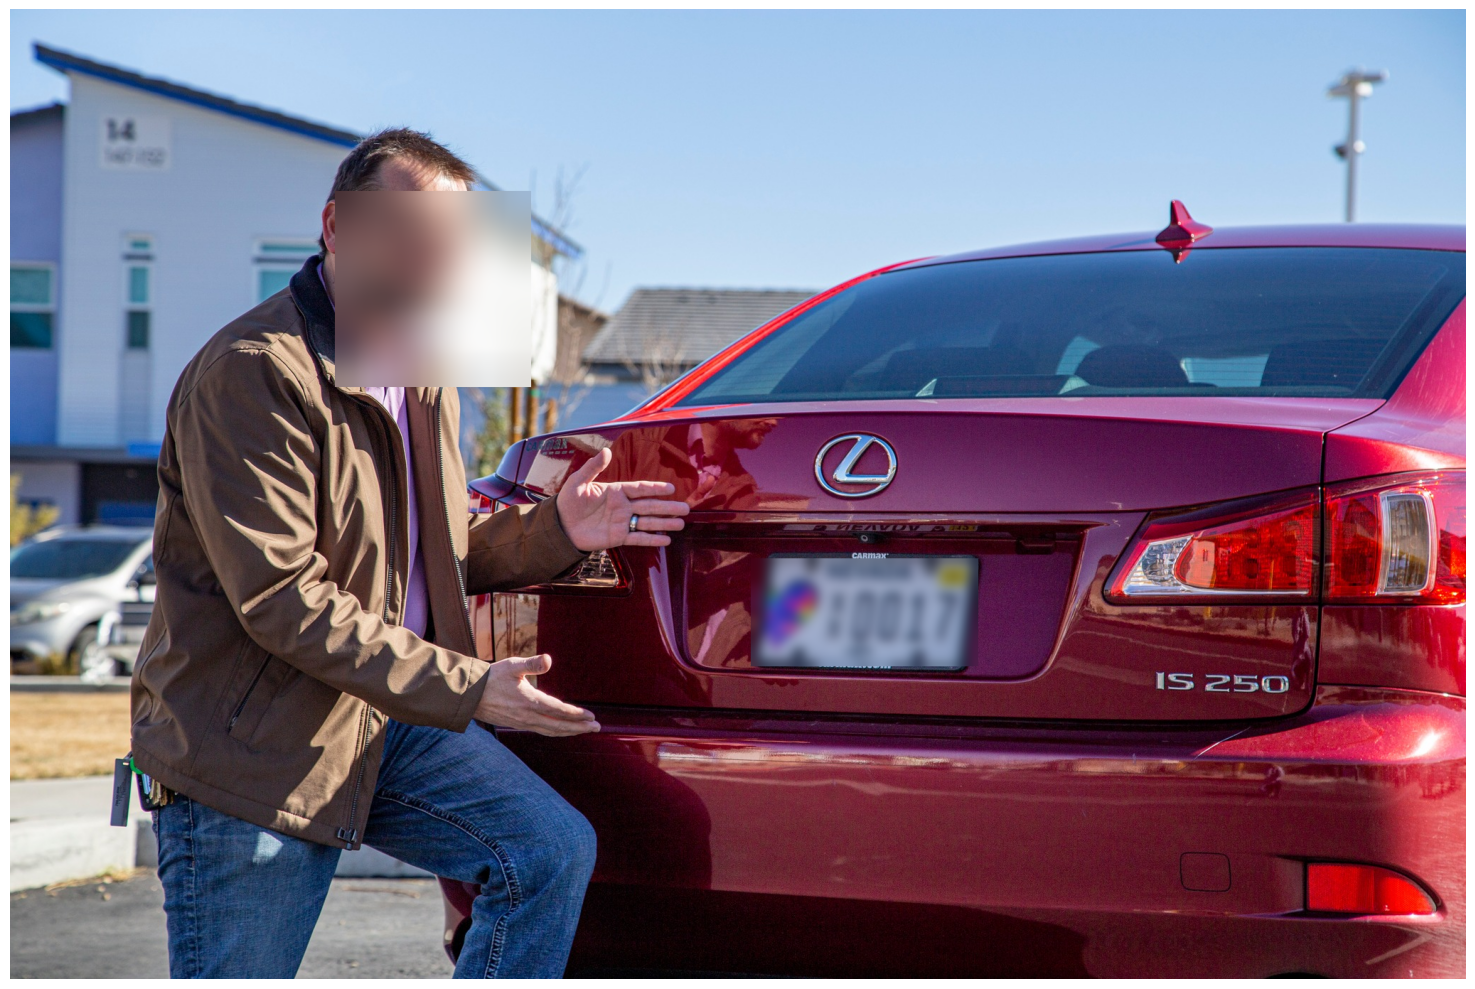

In [18]:
processed_image, plate_prediction, plates_detected = detect_and_blur_plates(processed_image)
# Display results
plt.figure(figsize=(15, 10))
plt.imshow(processed_image)
plt.axis('off')
plt.tight_layout()
plt.show()